In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso
from scipy import stats

## Data visualization

In [13]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")

all_df.info()
all_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 120 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(11), object(1)
memory usage: 375.1+ KB


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,12.727500,56.159792,51.851171,0.540000,2.900000,2.81000,2.830000,9.880000,6.577500,8.625000,...,3.945420e-01,3.899257e-01,2.711993e+00,0.003314,5.683152e+07,176.969142,32500.032680,0.056721,0.005948,0.029385
std,111.104111,26.763774,10.864462,0.499022,49.932235,49.93649,49.935558,86.092482,70.443308,86.200962,...,1.674769e-01,1.624792e-01,7.556631e-01,0.002412,7.063822e+08,1045.305721,177545.921557,0.047363,0.008416,0.115909
min,0.000000,5.000000,23.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.616016,0.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,3.199017e-01,3.175584e-01,2.330664e+00,0.001334,1.078546e+06,18.628013,0.001851,0.018628,0.000310,0.001535
50%,0.000000,55.041667,51.119781,1.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,4.095627e-01,4.054695e-01,2.807355e+00,0.002888,3.366594e+06,66.507214,0.004399,0.047029,0.002301,0.003384
75%,1.000000,73.000000,60.000000,1.000000,1.000000,1.00000,1.000000,3.000000,2.000000,1.000000,...,5.000660e-01,4.962633e-01,3.277613e+00,0.004707,9.231697e+06,154.300334,0.013846,0.084418,0.007873,0.009558
max,999.000000,144.000000,79.603012,1.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


<AxesSubplot:ylabel='RelapseFreeSurvival (outcome)'>

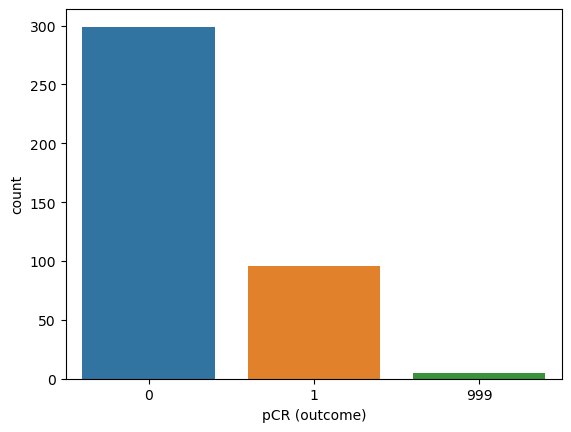

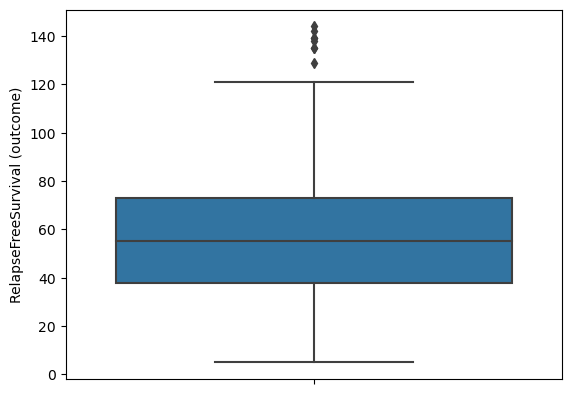

In [14]:
# countplot and boxplot for both classification and regression outcome
sns.countplot(x="pCR (outcome)", data=all_df)
plt.figure()
sns.boxplot(y='RelapseFreeSurvival (outcome)', data=all_df)

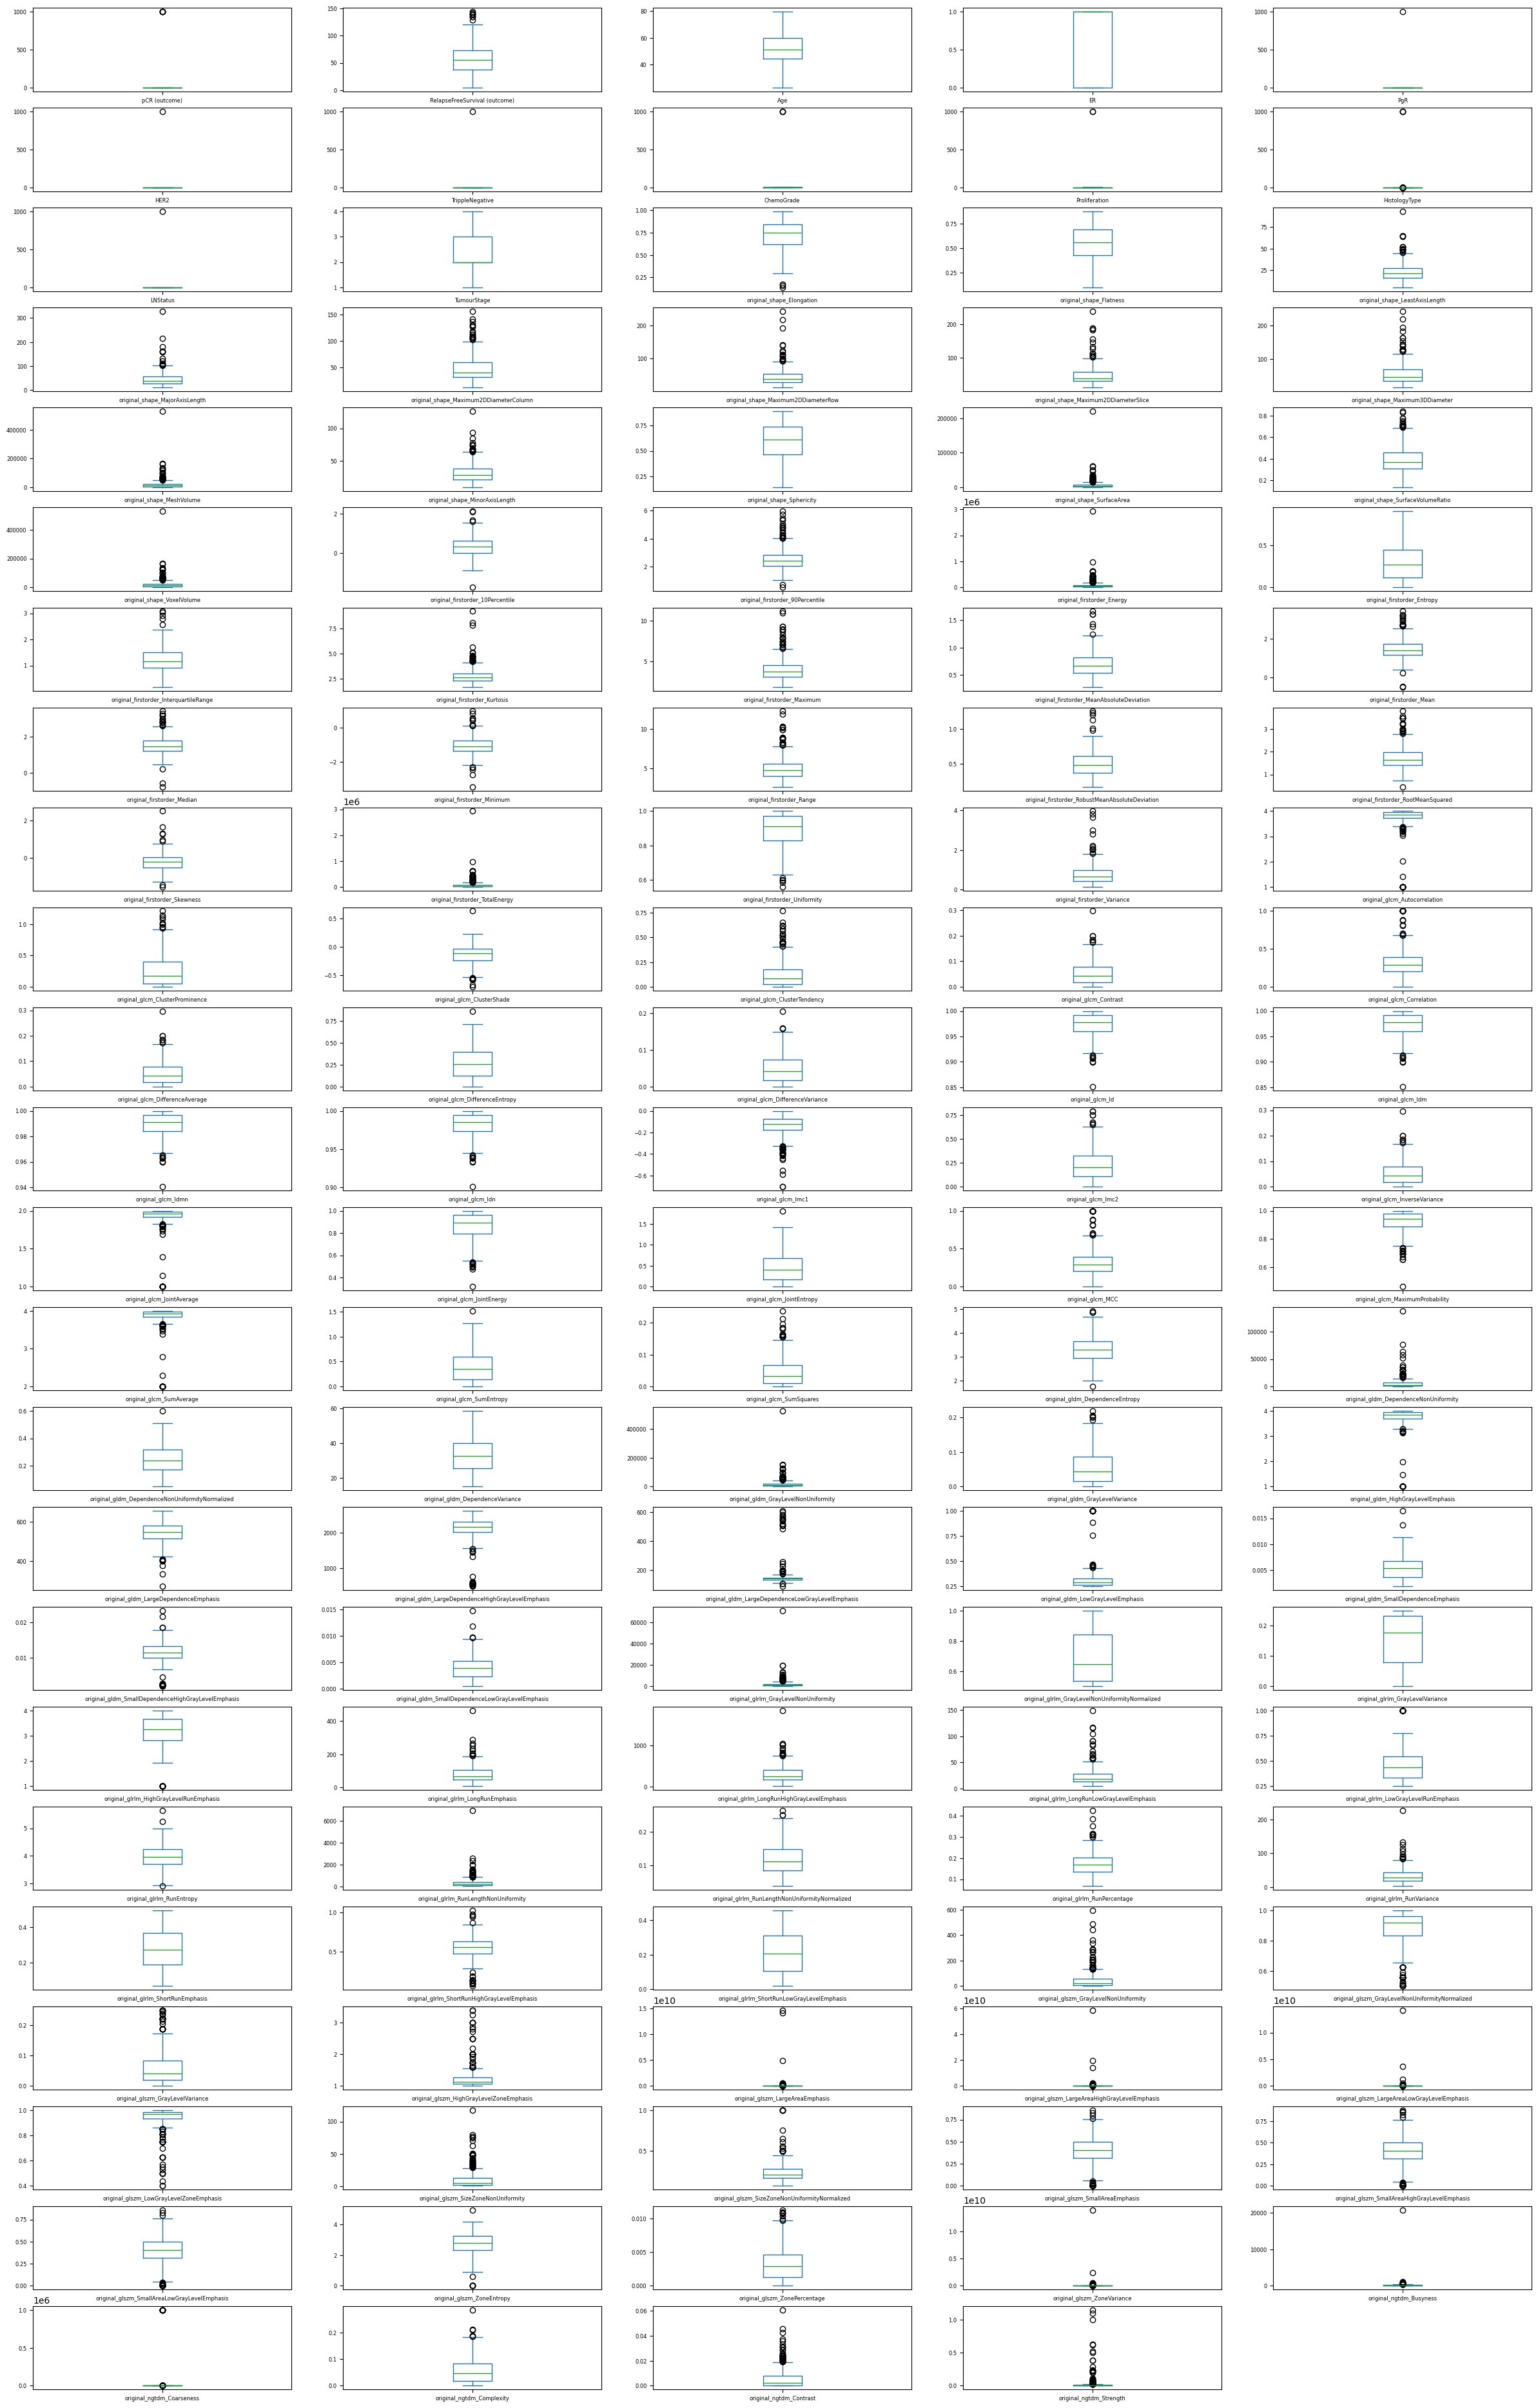

In [15]:
# boxplot for all features
all_df.plot(kind='box', subplots=True, layout=(25, 5), sharex=False,
            sharey=False, fontsize=6, figsize=(30, 50));

## Data pre-processing

#### Data imputation

- Dropping rows which has several missing values

In [16]:
# for now, we only delete rows which has 3 missing values, row 258 only has 2 missing values
# note that excel sheet starts from row 2 while dataframe starts from index 0
# all_df.drop([218, 253, 258, 287])
all_df = all_df.drop([218, 253, 285])

# retain the original dataset with ID column to be used in the future
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

- Using most frequent values, KNN and multivariate imputer respectively

In [17]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

k_imp = KNNImputer()
k_imputed_array = k_imp.fit_transform(new_df)

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    k_imputed_array[row][col] = np.round(k_imputed_array[row][col])
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])
    print(k_imputed_array[row][col], multi_imputed_array[row][col])

# convert to dataFrame
k_imputed_df = pd.DataFrame(k_imputed_array, columns=column_names)
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# write imputed dataframe into excel sheet
k_imputed_df.to_excel('./knnImputedDataset.xlsx', sheet_name='Sheet 1', index=False)
multi_imputed_df.to_excel('./multivariateImputedDataset.xlsx', sheet_name='Sheet 1', index=False)

0.0 0.0
3.0 3.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0


## Feature normalisation

pCR (outcome)                       AxesSubplot(0.125,0.83;0.227941x0.05)
RelapseFreeSurvival (outcome)    AxesSubplot(0.398529,0.83;0.227941x0.05)
Age                              AxesSubplot(0.672059,0.83;0.227941x0.05)
ER                                  AxesSubplot(0.125,0.77;0.227941x0.05)
PgR                              AxesSubplot(0.398529,0.77;0.227941x0.05)
HER2                             AxesSubplot(0.672059,0.77;0.227941x0.05)
TrippleNegative                     AxesSubplot(0.125,0.71;0.227941x0.05)
ChemoGrade                       AxesSubplot(0.398529,0.71;0.227941x0.05)
Proliferation                    AxesSubplot(0.672059,0.71;0.227941x0.05)
HistologyType                       AxesSubplot(0.125,0.65;0.227941x0.05)
LNStatus                         AxesSubplot(0.398529,0.65;0.227941x0.05)
TumourStage                      AxesSubplot(0.672059,0.65;0.227941x0.05)
original_shape_Elongation           AxesSubplot(0.125,0.59;0.227941x0.05)
dtype: object

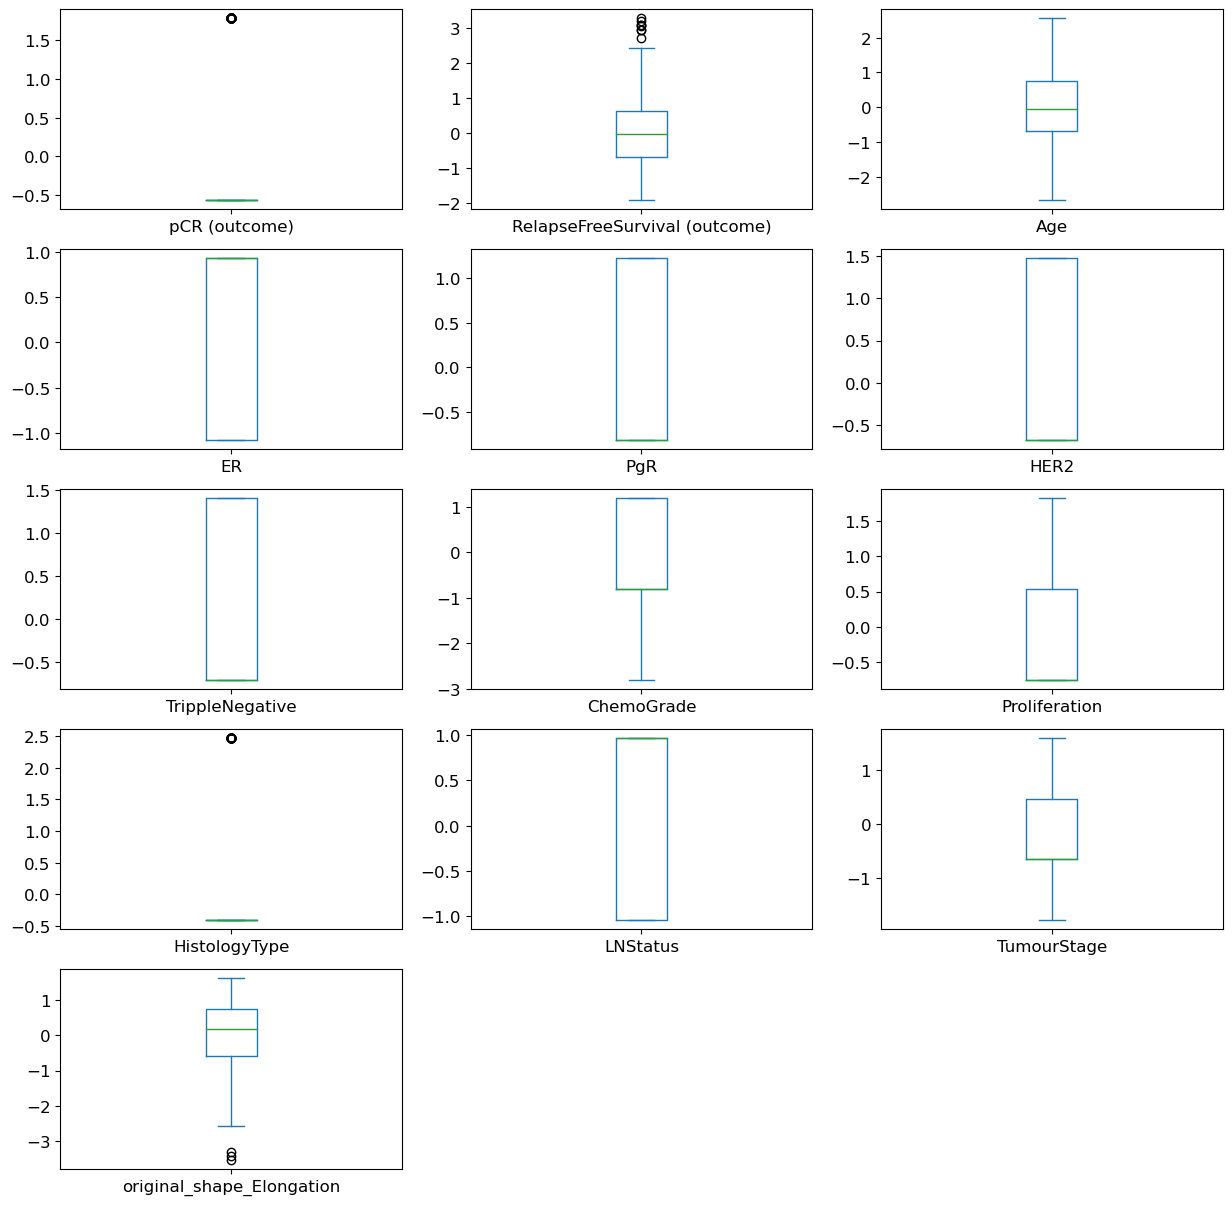

In [18]:
# KNN imputed
scaler = StandardScaler()
k_imputed_n_df = pd.DataFrame(scaler.fit_transform(k_imputed_df), columns=k_imputed_df.columns)

# only plot the clinic features
cf_df = k_imputed_n_df.iloc[:,0:13]
cf_df.plot(kind='box', subplots=True, layout=(13, 3), sharex=False, sharey=False, fontsize=12, figsize=(15,40))

pCR (outcome)                       AxesSubplot(0.125,0.83;0.227941x0.05)
RelapseFreeSurvival (outcome)    AxesSubplot(0.398529,0.83;0.227941x0.05)
Age                              AxesSubplot(0.672059,0.83;0.227941x0.05)
ER                                  AxesSubplot(0.125,0.77;0.227941x0.05)
PgR                              AxesSubplot(0.398529,0.77;0.227941x0.05)
HER2                             AxesSubplot(0.672059,0.77;0.227941x0.05)
TrippleNegative                     AxesSubplot(0.125,0.71;0.227941x0.05)
ChemoGrade                       AxesSubplot(0.398529,0.71;0.227941x0.05)
Proliferation                    AxesSubplot(0.672059,0.71;0.227941x0.05)
HistologyType                       AxesSubplot(0.125,0.65;0.227941x0.05)
LNStatus                         AxesSubplot(0.398529,0.65;0.227941x0.05)
TumourStage                      AxesSubplot(0.672059,0.65;0.227941x0.05)
original_shape_Elongation           AxesSubplot(0.125,0.59;0.227941x0.05)
dtype: object

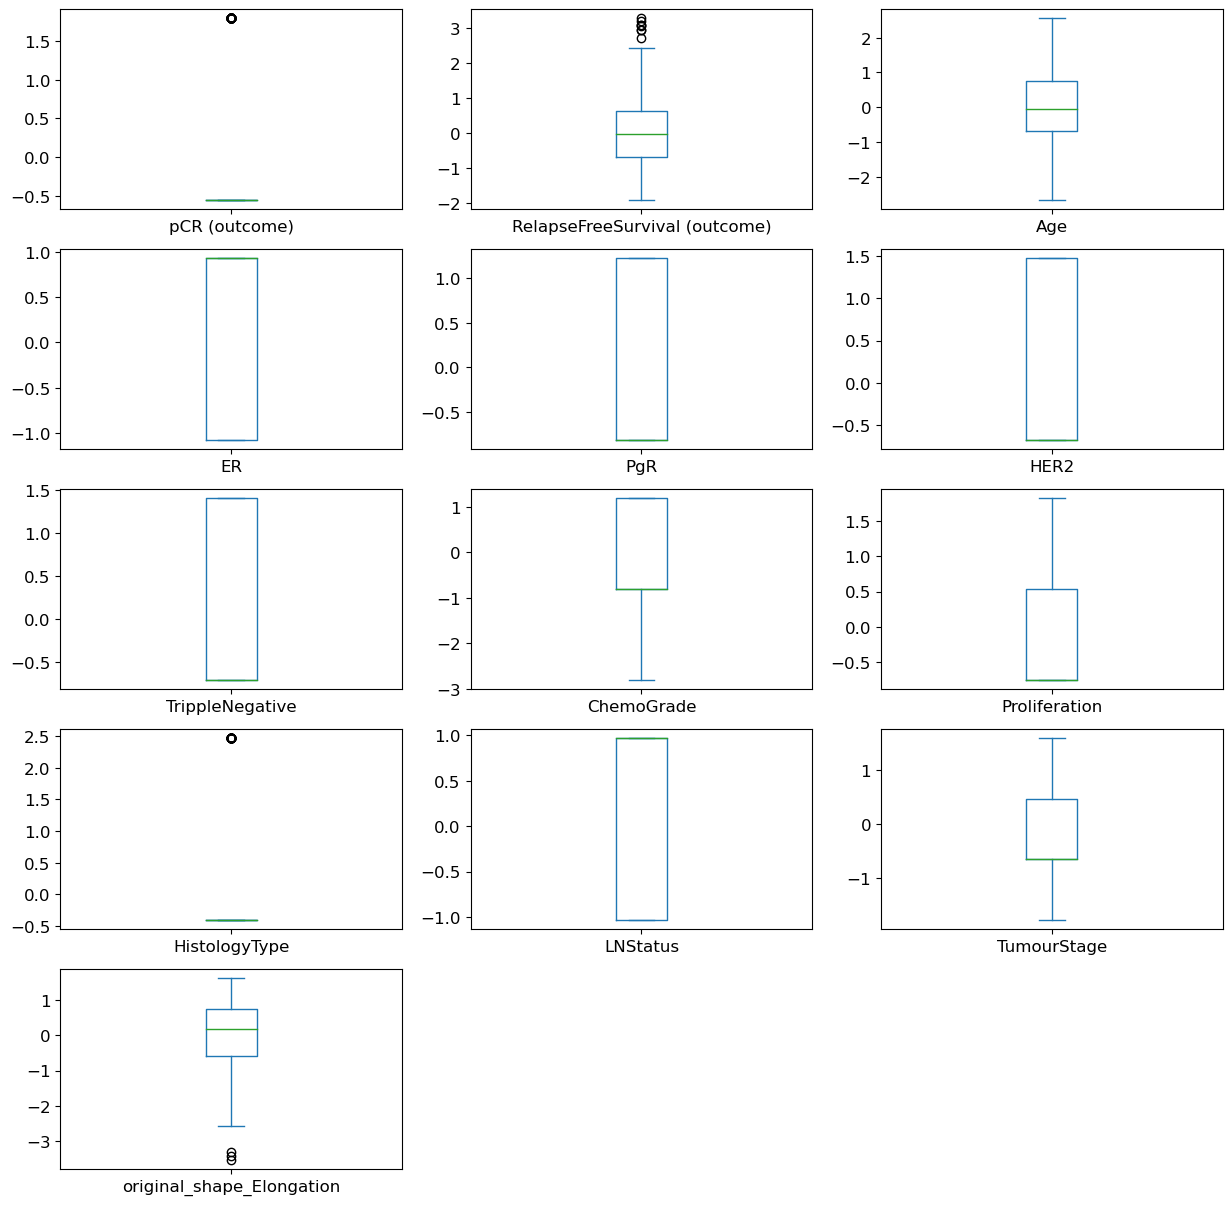

In [19]:
# multivariate imputer
scaler = StandardScaler()
multi_imputed_n_df = pd.DataFrame(scaler.fit_transform(multi_imputed_df), columns=multi_imputed_df.columns)

cf_df = multi_imputed_n_df.iloc[:,0:13]
cf_df.plot(kind='box', subplots=True, layout=(13, 3), sharex=False, sharey=False, fontsize=12, figsize=(15,40))

## Feature Selection

- Using ANOVA for Feature Slection. As stated in sklearn doc, chi2 is not applicable to negatige values and T test works on binary classes so neither is used here

In [20]:
X_k_imputed_df = k_imputed_df.drop(['RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1).copy()
y_cla_k_imputed_df = k_imputed_df['pCR (outcome)'].copy()
y_reg_k_imputed_df = k_imputed_df['RelapseFreeSurvival (outcome)'].copy()

# only considering classcification for the time being
X_k_imputed_fs = SelectKBest(f_classif, k = 50).fit_transform(X_k_imputed_df, y_cla_k_imputed_df)

# the first 5 oberservations
X_k_imputed_fs[:5,:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         3.28443703e+01,  3.86264158e+01,  2.67324397e+01,
         2.58736113e-01, -1.63500430e-01,  7.38087895e-01,
         2.48168276e-01,  2.17627728e-01,  6.70258197e-01,
         1.41573784e-01,  7.25848579e-01,  4.38759604e-01,
         1.84265431e-01,  1.84265431e-01,  6.85679739e-01,
         1.49584782e-01,  9.07867284e-01,  9.07867284e-01,
         9.63146914e-01,  9.38578190e-01,  1.84265431e-01,
         5.38902701e-01,  1.30920329e+00,  7.14849459e-01,
         1.12493786e+00,  1.55756259e-01,  4.52946088e+00,
         8.16352760e-02,  3.82337944e+01,  1.64870902e-01,
         4.56983173e+02,  2.48329340e-01,  3.61910865e+01,
         1.37835476e+02,  1.07799890e+01,  3.86581103e+00,
         1.84873598e-01,  2.51408971e-01,  1.91388112e+01,
         4.09396085e-01,  7.89986585e-01,  4.73464852e+02,
         1.82614990e-01,  3.05076850e-02],
       [ 1.00

- Similarly, the ANOVA for multivariate imputer

In [21]:
X_multi_imputed_n_df = multi_imputed_n_df.drop(['RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1).copy()
y_cla_multi_imputed_n_df = multi_imputed_n_df['pCR (outcome)'].copy()
y_reg_multi_imputed_n_df = multi_imputed_n_df['RelapseFreeSurvival (outcome)'].copy()

X_k_imputed_fs = SelectKBest(f_classif, k = 50).fit_transform(X_multi_imputed_n_df, y_cla_multi_imputed_n_df)

X_k_imputed_fs[:5,:]

array([[-1.07592225, -0.8173538 , -0.67790768,  1.83180805,  0.96777341,
        -0.65875073, -0.2358966 , -0.30663144, -1.08930545, -1.02976377,
         1.96236982, -2.48703505, -2.6672551 , -2.15696958, -1.27459109,
         1.81384426,  2.28796329,  2.87171529,  2.87171529,  2.30657227,
         2.64593305, -2.87171531, -2.87171531, -2.87171525, -2.87171527,
         2.87171529, -2.5984941 ,  2.43443526, -2.71915507,  2.35479585,
         2.50678827,  2.32893425, -1.70539386,  0.54452509,  2.15696959,
        -1.66495228, -1.12465892,  1.12465892, -0.90684392, -0.87407336,
        -0.21967838,  1.47406418,  1.57637101, -0.62816622,  1.24821933,
         1.76246553,  0.8902854 ,  0.28209362,  2.65236892,  2.91021996],
       [ 0.92943519,  1.2234604 , -0.67790768,  1.83180805,  0.96777341,
        -0.65875073, -0.11432043, -0.15608702, -0.50858417,  0.62744764,
        -0.54014728,  0.14947407,  0.21151472,  0.60192177, -0.667105  ,
        -0.72801883, -0.6451509 , -0.55827706, -0.

- Another try is based on how the image-based feature names suggest related variables so we can only select a few most dominant ones from each group 

In [25]:
grouped_fs = X_k_imputed_df.iloc[:,:11].to_numpy()
shape = X_k_imputed_df.iloc[:,11:25]
firstorder = X_k_imputed_df.iloc[:, 25:43]
glcm = X_k_imputed_df.iloc[:, 43:67]
gldm = X_k_imputed_df.iloc[:, 67:81]
glrlm = X_k_imputed_df.iloc[:, 81:97]
glszm = X_k_imputed_df.iloc[:, 97:113]
ngtdm = X_k_imputed_df.iloc[:, 113:]

ibf_lists = [shape, firstorder, glcm, gldm, glrlm, glszm, ngtdm]

for data in ibf_lists:
    data_fs = SelectKBest(f_classif, k = 4).fit_transform(data, y_cla_k_imputed_df)
    grouped_fs = np.concatenate((grouped_fs, data_fs), axis=1)

grouped_fs[5:,:]

array([[4.9000000e+01, 0.0000000e+00, 0.0000000e+00, ..., 5.3378380e-02,
        2.7704710e-03, 2.2627170e-03],
       [5.6000000e+01, 0.0000000e+00, 0.0000000e+00, ..., 2.1567000e-02,
        4.4553600e-04, 1.6685170e-03],
       [4.1000000e+01, 0.0000000e+00, 0.0000000e+00, ..., 6.9696909e-02,
        4.2848680e-03, 2.4747550e-03],
       ...,
       [6.8800000e+01, 1.0000000e+00, 0.0000000e+00, ..., 5.4062718e-02,
        3.6966650e-03, 1.3679770e-03],
       [4.6000000e+01, 1.0000000e+00, 0.0000000e+00, ..., 1.8681596e-02,
        3.1105600e-04, 2.2676177e-02],
       [5.5300000e+01, 0.0000000e+00, 0.0000000e+00, ..., 5.5150839e-02,
        3.0537260e-03, 3.4245200e-03]])

## Dimensionality reduction

- An interesting try in contrast to FS methods

In [26]:
pca = PCA(n_components=50)
pca.fit(X_k_imputed_df)
X_reduced_k_imputed_df = pca.transform(X_k_imputed_df)

- Applying PCA similar to to each image based feature group

In [28]:
grouped_dr = X_k_imputed_df.iloc[:,:12].to_numpy()
ibf_lists = [shape, firstorder, glcm, gldm, glrlm, glszm, ngtdm]

for data in ibf_lists:
    pca = PCA(n_components=0.99)
    pca.fit(data)
    grouped_dr = np.concatenate((grouped_dr, pca.transform(data)), axis=1)

grouped_dr[5:,:]

array([[ 4.90000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -3.20728206e+08, -2.52789758e+07, -3.27456221e+04],
       [ 5.60000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -2.79733852e+08, -2.83046976e+07, -3.27456228e+04],
       [ 4.10000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -3.23987520e+08, -2.50394593e+07, -3.27456219e+04],
       ...,
       [ 6.88000000e+01,  1.00000000e+00,  0.00000000e+00, ...,
        -2.40288152e+08, -3.09768390e+07, -3.27456234e+04],
       [ 4.60000000e+01,  1.00000000e+00,  0.00000000e+00, ...,
        -3.25947892e+08, -2.48925239e+07, -3.27455982e+04],
       [ 5.53000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -3.21622911e+08, -2.52091475e+07, -3.27456210e+04]])

## Regression

In [29]:
test_df = pd.read_excel("./Dataset/testDatasetExample.xls",sheet_name="Sheet1")
test_df.drop('ID', axis=1, inplace=True)
test_df.head

<bound method NDFrame.head of          Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  Proliferation  \
0  56.881588   0    0     0                1           3              3   
1  60.000000   0    0     1                0           2              1   
2  58.234086   0    0     0                1           3              3   

   HistologyType  LNStatus  TumourStage  ...  \
0            999         0            2  ...   
1              1         0            3  ...   
2              1         1            4  ...   

   original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                       0.194591   
1                                       0.309999   
2                                       0.328377   

   original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                                      0.194591                    2.846439   
1                                      0.309996                    2.975317   
2                             

- Using LASSO as embeded FS model

In [31]:
clf = Lasso(alpha=0.2)
clf.fit(X_k_imputed_df, y_reg_k_imputed_df)
clf.predict(test_df)

array([56.05420657, 56.16802694, 40.00890938])